# Senzing + Neo4j: Analyze impact of ERKG

## Set up the Python environment

First, we need to import the Python library dependencies which are required for the code we'll be running.

In [1]:
import os

from graphdatascience import GraphDataScience 
from icecream import ic
from tqdm import tqdm
import dotenv
import matplotlib.pyplot as plt
import pandas as pd
import pyvis
import seaborn as sns
import watermark

%load_ext watermark

Show a "watermark" of which versions are being used for system componenents and library dependencies. This may help in case you need to troubleshoot the dependencies on your system, e.g., if there's some conflict during installation.

In [2]:
%watermark
%watermark --iversions

Last updated: 2024-04-11T21:40:01.293760-07:00

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.23.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.1
matplotlib: 3.8.4
seaborn   : 0.13.2
watermark : 2.4.3
pyvis     : 0.3.2



## Connect the GDS library to Neo4j Desktop

Set up a GDS connection using our credentials for Neo4j Desktop

In [3]:
dotenv.load_dotenv(dotenv.find_dotenv())

bolt_uri: str = os.environ.get("NEO4J_BOLT")
database: str = os.environ.get("NEO4J_DBMS")
username: str = os.environ.get("NEO4J_USER")
password: str = os.environ.get("NEO4J_PASS")

gds:GraphDataScience = GraphDataScience(
    bolt_uri,
    auth = ( username, password, ),
    database = database,
    aura_ds = False,
)

## Analyze the impact of ER

Now let's analyze the Senzing results, measuring how much the process of _entity resolution_ has consolidated records among the input datasets.
In particular, it's helpful to understand:

  - total number of entities
  - number of entities with linked reference (should be 100% in the graph)
  - number of linked records per entity
  - number of related entities per entity

In [4]:
df_ent: pd.DataFrame = gds.run_cypher(
  """
MATCH (ent:Entity)
RETURN ent.uid AS ent_uid, COUNT { (ent)-[:RESOLVES]->(:Record) } AS num_rec, COUNT { (ent)-[:RELATED]->(:Entity) } AS num_rel
ORDER BY num_rec DESC
  """
)

df_rec: pd.DataFrame = gds.run_cypher(
  """
MATCH (ent:Entity)
RETURN COUNT(ent.uid) AS count_ent, COUNT { (ent)-[:RESOLVES]->(:Record) } AS num_rec
ORDER BY num_rec DESC
  """
)

df_rel: pd.DataFrame = gds.run_cypher(
  """
MATCH (ent:Entity)
RETURN COUNT(ent.uid) AS count_ent, COUNT { (ent)-[:RELATED]->(:Entity) } AS num_rel
ORDER BY num_rel DESC
  """
)

In [5]:
total_entities: int = df_ent.ent_uid.count()
total_records: int = df_ent.num_rec.sum()
unref_ents: int = df_rec.loc[df_rec["num_rec"] < 1].count().iloc[0]
dupl_rate: float = round((total_records - total_entities) / float(total_entities), 2)

ic(total_entities, total_records, unref_ents, dupl_rate);

ic| total_entities: 83386
    total_records: 84988
    unref_ents: 0
    dupl_rate: 0.02


Great, 100% of the input records have been resolved as entities – as expected.
A rate of ~2% duplicates was detected among these records.

Now let's run more detailed statistical analysis, visualizing a histogram of the resolved entities versus their related records from the input datasets.

In [6]:
df_ent.describe()

,ent_uid,num_rec,num_rel
count,83386.000000,83386.000000,83386.000000
mean,45603.987204,1.019212,4.134459
std,36222.739725,0.173885,6.380714
min,1.000000,1.000000,0.000000
25%,20905.250000,1.000000,1.000000
50%,41770.500000,1.000000,3.000000
75%,62639.750000,1.000000,6.000000
max,203487.000000,14.000000,326.000000


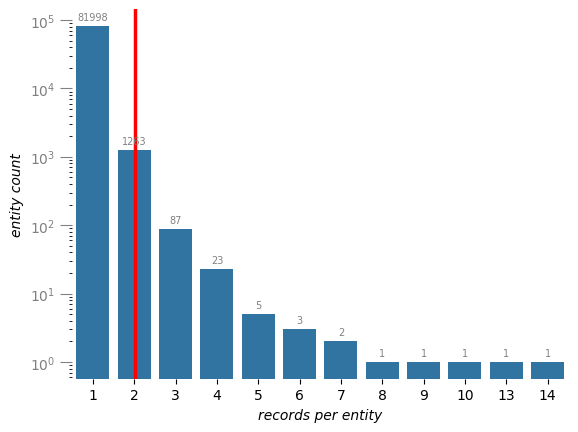

In [7]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "sans-serif"

y = sns.barplot(df_rec, y = "count_ent", x = "num_rec")
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("records per entity", size = 10, fontstyle = "italic")
plt.ylabel("entity count", size = 10, fontstyle = "italic")

rec_mean: float = df_ent.num_rec.mean()
plt.axvline(x = rec_mean, color = "red", lw = 2.5)

sns.despine(bottom = True, left = True)
plt.yscale("log")

fig.savefig("../article/img/graphs.plot.ent_rec.png")

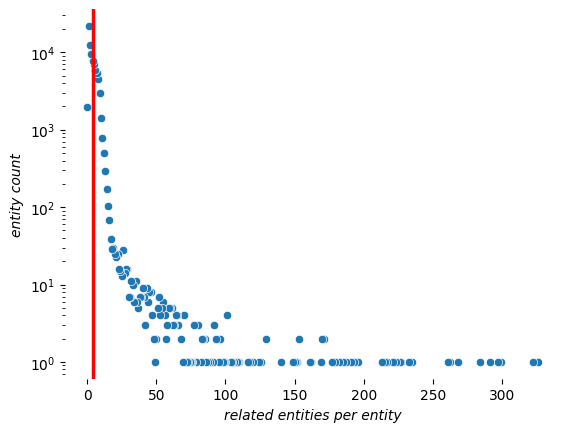

In [8]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "sans-serif"

y = sns.scatterplot(df_rel, y = "count_ent", x = "num_rel")

plt.xlabel("related entities per entity", size = 10, fontstyle = "italic")
plt.ylabel("entity count", size = 10, fontstyle = "italic")

rel_mean: float = df_ent.num_rel.mean()
plt.axvline(x = rel_mean, color = "red", lw = 2.5)

sns.despine(bottom = True, left = True)
plt.yscale("log")

fig.savefig("../article/img/graphs.plot.ent_rel.png")

## Graph visualizations

In [9]:
df_link_rec = gds.run_cypher(
  """
MATCH (ent:Entity)-[rel:RESOLVES]->(rec:Record)
RETURN ent.uid AS ent_uid, ent.name AS ent_name, COUNT { (ent)-[:RESOLVES]->(:Record) } as num_rec, rec.uid AS rec_uid, rec.name AS rec_name, rel.match_key AS match_key
  """
)

MIN_DEGREE: int = 3  # adjust lower to view a larger graph

df_link_rec = df_link_rec.loc[df_link_rec["num_rec"] >= MIN_DEGREE]

In [10]:
net: pyvis.network.Network = pyvis.network.Network(notebook = True)

for _, row in df_link_rec.iterrows():
    net.add_node(
        row.rec_uid,
        label = row.rec_name,
        color = "blue",
        shape = "square",
    )

net.toggle_physics(True)
net.show("vegas.1.html")

vegas.1.html


In [11]:
df_link_rel: pd.DataFrame = gds.run_cypher(
  """
MATCH (ent:Entity)-[rel:RELATED]->(rel_ent:Entity)
RETURN ent.uid AS ent_uid, rel.match_key AS match_key, rel_ent.uid AS rel_uid, rel_ent.name AS rel_name
  """
)

In [12]:
net: pyvis.network.Network = pyvis.network.Network(notebook = True)

for _, row in df_link_rec.iterrows():
    net.add_node(
        row.rec_uid,
        label = row.rec_name,
        color = "blue",
        shape = "square",
        size = 10,
    )
    
    net.add_node(
        row.ent_uid,
        label = row.ent_name,
        color = "red",
        shape = "star",
        size = row.num_rec,
    )
    
    edge = net.add_edge(
        row.rec_uid,
        row.ent_uid,
        label = row.match_key,
        color = "green",
        #value = 1.0,
    )

# enumerate the nodes, so we can do efficient lookups later
node_ids: dict = {
    node["id"]: i
    for i, node in enumerate(net.nodes)
}

# link the nodes/edges for "RELATED" entities
for _, row in df_link_rel.iterrows():
    if row.ent_uid in node_ids:
        if row.rel_uid not in node_ids:
            net.add_node(
                row.rel_uid,
                label = row.rel_name,
                color = "gray",
                shape = "star",
                size = 4,
            )

        edge = net.add_edge(
            row.ent_uid,
            row.rel_uid,
            title = row.match_key,
            color = "#d3d3d3",
        )

# add titles (flyover HTML) to show the properties for each node
df_recs: pd.DataFrame = gds.run_cypher("""
MATCH (ent:Entity)-[rel:RESOLVES]->(rec:Record)
RETURN rec.uid AS rec_uid, properties(rec) as props
""")

for _, row in df_recs.iterrows():
    if row.rec_uid in node_ids:
        title: str = "\n".join([
            f"{key}: {val}"
            for key, val in row.props.items()
        ])
        net.nodes[node_ids[row.rec_uid]]["title"] = title

# set the font size and color for nodes and edges
for node in net.nodes:
    if "label" in node:
        node["font"] = {
            "size": 9,
            "color": "gray",
        }

for edge in net.edges:
    if "label" in edge:
        edge["font"] = {
            "size": 8,
            "color": "green",
        }

# visualize as HTML
net.toggle_physics(True)
net.show("vegas.2.html")

vegas.2.html
